In [1]:
import random
from pathlib import Path

import numpy as np
import torch

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

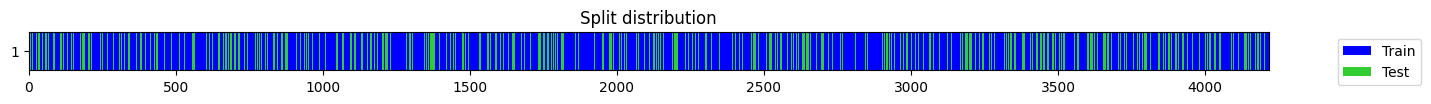

epoch,train_loss,valid_loss,mae,_rmse,mape,time
0,0.281532,0.246628,0.469474,0.496616,0.615663,00:02
1,0.207906,0.066947,0.201371,0.258741,0.237691,00:02
2,0.126298,0.026916,0.146251,0.164062,0.193497,00:02
3,0.083938,0.028990,0.159725,0.170263,0.230744,00:02
4,0.060367,0.026589,0.151577,0.163062,0.209909,00:02
5,0.046550,0.026589,0.151850,0.163061,0.211083,00:02
6,0.038313,0.026633,0.145462,0.163196,0.192371,00:02
7,0.033319,0.026599,0.144682,0.163093,0.190676,00:02
8,0.030195,0.026116,0.145241,0.161604,0.193437,00:02
9,0.028058,0.024269,0.137533,0.155784,0.182246,00:02


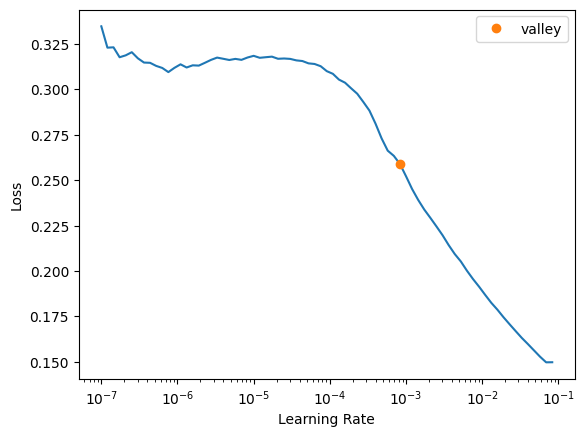

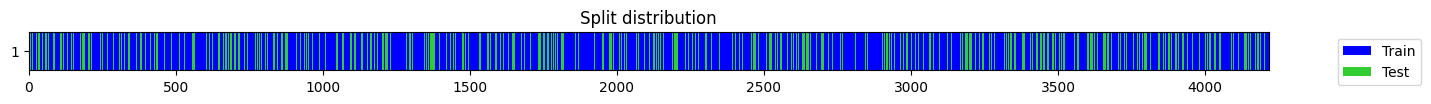

epoch,train_loss,valid_loss,mae,_rmse,mape,time
0,0.143435,0.027950,0.121383,0.167182,0.154066,00:02
1,0.075962,0.035471,0.126808,0.188338,0.153312,00:02
2,0.051547,0.022149,0.136543,0.148826,0.198387,00:02
3,0.038417,0.022441,0.129704,0.149802,0.181538,00:02
4,0.031379,0.022082,0.139565,0.148599,0.207135,00:02
5,0.027224,0.022487,0.127232,0.149956,0.175508,00:02
6,0.024645,0.022251,0.126337,0.149167,0.174021,00:02
7,0.023096,0.020774,0.132801,0.144133,0.194379,00:02
8,0.022128,0.023415,0.112747,0.153021,0.144555,00:02
9,0.018718,0.011587,0.075936,0.107643,0.101870,00:02


,ip,mae_score,rmse_score,mape_score,0,1,2,3,4,5,6
0,10.138.192.133,TensorBase(0.0149),TensorBase(0.0233),TensorBase(0.0204),17.233881,17.918548,18.244739,16.227797,16.214760,16.544153,16.083301
1,10.138.192.5,TensorBase(0.0086),TensorBase(0.0121),TensorBase(0.0139),17.940270,17.439089,18.051931,16.480996,16.517263,16.278442,16.092551


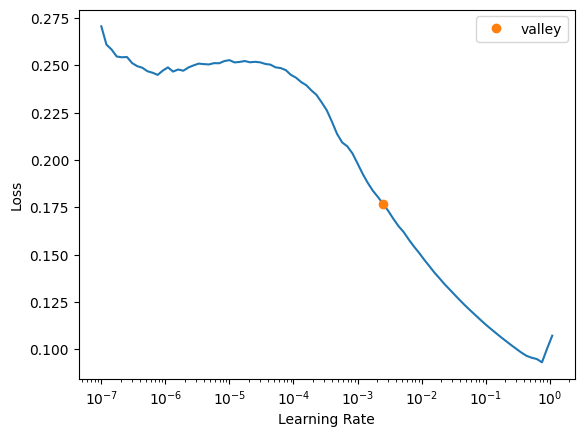

In [2]:
from forecast import train_ips

train_ips(
    ips=['10.138.192.133', '10.138.192.5'],
    base_path=Path('./data/dfyj/key1_20240618_20240718'),
    device=device,
    epochs=50
)